### **1. Libraries and Configurations**
----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### **2. Importing Dataset**
----

In [3]:
df = pd.read_csv('startup_failure_prediction.csv', encoding='ISO-8859-1')
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **3. Dataset Validation**
----

In [4]:
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.')

The dataset have 39 columns and 54294 rows.


In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
# Let's drop the non-usable columns

drop = ['permalink', 'name', 'homepage_url', 'category_list',
        'founded_month', 'founded_quarter', 'founded_year']

for col in drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [7]:
# The goal is to predict whether a startup failed (closed) or succeeded (acquired).
# We restrict the dataset to these two outcomes and encode them into a binary target variable.

df = df[df['status'].isin(['acquired', 'closed'])].copy()
df['failed'] = df['status'].map({'closed': 1, 'acquired': 0})
df.drop('status', axis=1, inplace=True)
df['failed'].value_counts()

failed
0    3692
1    2603
Name: count, dtype: int64

In [8]:
print(f'The dataset have {df.shape[1]} columns and {df.shape[0]} rows.\n')

The dataset have 32 columns and 6295 rows.



### **4. Data Cleaning & Preprocessing**
----

#### **4.1. Ajust in the Main Columns**
----

In [9]:
df_clean = df.copy()

In [10]:
# Converting to datetime the founded_at column:

df_clean['founded_at'] = pd.to_datetime(df_clean['founded_at'], errors='coerce')
df_clean['first_funding_at'] = pd.to_datetime(df_clean['first_funding_at'], errors='coerce')
df_clean['last_funding_at'] = pd.to_datetime(df_clean['last_funding_at'], errors='coerce')

In [11]:
# Standardizing the funding_total_usd column:

df_clean['funding_total_usd'] = df_clean['funding_total_usd'].str.strip().str.lower().str.replace(',', '')
df_clean['funding_total_usd'] = pd.to_numeric(df_clean['funding_total_usd'], errors='coerce')

In [12]:
# If the startup is not from the USA, mark its state_code and country_code as 'FGN' (foreign):

df_clean.loc[df_clean['country_code'] != 'USA', 'state_code'] = 'FGN'
df_clean.loc[df_clean['country_code'] != 'USA', 'country_code'] = 'FGN'


In [13]:
# Let's drop region/city column. It's too cardinality:

drop = ['region', 'city']

for col in drop:
    if col in df_clean.columns:
        df_clean.drop(columns=col, inplace=True)

#### **4.2. Treatment of Null Values**
----

In [14]:
null_cols = df_clean.isnull().sum()
null_cols = null_cols[null_cols > 0]
null_cols

market                231
funding_total_usd     919
founded_at           1323
first_funding_at        1
dtype: int64

In [15]:
# Remove rows with missing or invalid 'first_funding_at':

df_clean = df_clean.dropna(subset=['first_funding_at'])

In [16]:
# Replacing missing with 'Unknown':

df_clean['market'] = df_clean['market'].fillna('Unknown')

In [17]:
# Creating a flag for missing founded_at:

df_clean['founded_missing'] = df_clean['founded_at'].isna().astype(int)

# Extracting year and month:

df_clean['founded_year'] = df_clean['founded_at'].dt.year
df_clean['founded_month'] = df_clean['founded_at'].dt.month

df_clean['first_funding_year'] = df_clean['first_funding_at'].dt.year
df_clean['first_funding_month'] = df_clean['first_funding_at'].dt.month

df_clean['last_funding_year'] = df_clean['last_funding_at'].dt.year
df_clean['last_funding_month'] = df_clean['last_funding_at'].dt.month

# Filling missing founded_year with median and founded_month with mode:

df_clean['founded_year'] = df_clean['founded_year'].fillna(df_clean['founded_year'].median())
df_clean['founded_month'] = df_clean['founded_month'].fillna(df_clean['founded_month'].mode()[0])

In [18]:
# Filling missing with 0 (no funding):

df_clean['funding_total_usd'] = df_clean['funding_total_usd'].fillna(0)

#### **4.3. Initial Feature Engineering**
----

In [19]:
# Calculate months between founded_at and first funding:

df_clean['months_to_first_funding'] = ((df_clean['first_funding_at'] - pd.to_datetime(df_clean['founded_year'].astype(int).astype(str) 
                                                                                      + '-' 
                                                                                      + df_clean['founded_month'].astype(int).astype(str) + '-01')) 
                                       / pd.Timedelta(days=30)).round(1)

In [20]:
# Calculate months between first and last funding:

df_clean['funding_duration_months'] = ((df_clean['last_funding_at'] - df_clean['first_funding_at']) / pd.Timedelta(days=30)).round(1)

In [21]:
df_clean.drop(['first_funding_at', 'last_funding_at', 'founded_at'], axis=1, inplace=True)

In [22]:
categorical = []
numerical = []

for col in df_clean.columns:
    if col == 'failed':
        continue
    if df_clean[col].dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)


Categorical columns: ['market', 'country_code', 'state_code']
Numerical columns: ['funding_total_usd', 'funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_a', 'round_b', 'round_c', 'round_d', 'round_e', 'round_f', 'round_g', 'round_h', 'founded_missing', 'founded_year', 'founded_month', 'first_funding_year', 'first_funding_month', 'last_funding_year', 'last_funding_month', 'months_to_first_funding', 'funding_duration_months']


### **5. Feature Engineering**
----

In [55]:
# Remove startups founded before 2000, as they are few and too old for this analysis:

df_clean = df_clean[df_clean['founded_year'] >= 2000]

df_final = df_clean.copy()

In [56]:
df_final = df_final[
    (df_final['first_funding_year'] >= df_final['founded_year']) &
    (df_final['last_funding_year'] >= df_final['first_funding_year']) &
    (df_final['months_to_first_funding'] >= 0)
]

#### **5.1. Categorical Features**
----

In [57]:
for col in categorical:
    df_final[col] = df_final[col].str.strip().str.lower().str.replace(' ', '_')

In [58]:
for col in categorical:
    print(f'Feature: {col}.')
    print(f'- Number of Categories: {df_final[col].nunique()}.')
    print(f'- Categories: {df_final[col].unique()}.')

Feature: market.
- Number of Categories: 380.
- Categories: ['news' 'advertising' 'marketplaces' 'analytics' 'curated_web'
 'e-commerce' 'lifestyle' 'finance' 'software' 'unknown'
 'electronic_health_records' 'games' 'semiconductors' 'web_hosting'
 'android' 'security' 'cloud_computing' 'automotive' 'photography' 'video'
 'internet_marketing' 'music' 'social_media' 'task_management'
 'virtual_worlds' 'public_relations' 'mobile' 'restaurants' 'seo'
 'biotechnology' 'health_care' 'career_management' 'vertical_search'
 'telecommunications' 'clean_technology' 'enterprise_software'
 'social_media_advertising' 'television' 'publishing'
 'facebook_applications' 'location_based_services' 'industrial'
 'entertainment' 'sales_and_marketing' 'health_and_wellness'
 'local_based_services' 'internet' 'auctions' 'displays' 'social_commerce'
 'clean_energy' 'hardware_+_software' 'saas' 'web_cms' 'wireless' 'iphone'
 'cloud_infrastructure' 'lighting' 'credit' 'web_development'
 'data_mining' 'sports' '

In [59]:
# Display top markets and cumulative percentage
# Helps to decide how many top categories to keep and group the rest as 'Other'

market_counts = df_final['market'].value_counts()

market_perc = market_counts / market_counts.sum() * 100

market_summary = pd.DataFrame({
    'count': market_counts,
    'percent': market_perc,
    'cumulative_percent': market_perc.cumsum()
})

market_summary.head(25) 


,count,percent,cumulative_percent
market,,,
software,492,10.108897,10.108897
curated_web,386,7.930964,18.039860
mobile,279,5.732484,23.772344
biotechnology,246,5.054448,28.826793
games,189,3.883296,32.710088
enterprise_software,188,3.862749,36.572837
advertising,186,3.821656,40.394494
e-commerce,143,2.938155,43.332648
social_media,129,2.650503,45.983152


In [60]:
# Keep top 25 most frequent markets (~70% coverage) and replace the rest with 'Other':

top_markets = df_final['market'].value_counts().head(25).index
df_final['market'] = df_final['market'].apply(lambda x: x if x in top_markets else 'other')

In [61]:
state_counts = df_final['state_code'].value_counts()

state_perc = state_counts / state_counts.sum() * 100

state_summary = pd.DataFrame({
    'count': state_counts,
    'percent': state_perc,
    'cumulative_percent': state_perc.cumsum()
})

state_summary.head(12)


,count,percent,cumulative_percent
state_code,,,
fgn,1585,32.566263,32.566263
ca,1565,32.155332,64.721594
ny,352,7.232381,71.953976
ma,248,5.095541,77.049517
wa,140,2.876515,79.926032
tx,136,2.794329,82.720362
co,84,1.725909,84.446271
pa,77,1.582083,86.028354
il,64,1.314978,87.343333


In [62]:
# Keep top 12 most frequent markets (~90% coverage) and replace the rest with 'Other':

top_states = df_final['state_code'].value_counts().head(12).index
df_final['state_code'] = df_final['state_code'].apply(lambda x: x if x in top_states else 'other')

In [63]:
for col in categorical:
    print(f'Feature: {col}.')
    print(f'- Number of Categories: {df_final[col].nunique()}.')

Feature: market.
- Number of Categories: 26.
Feature: country_code.
- Number of Categories: 2.
Feature: state_code.
- Number of Categories: 13.


#### **5.2. Numerical Features**
----

In [64]:
df_final[numerical].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
funding_total_usd,4867.0,1.409167e+07,9.552139e+07,0.0,180000.0,2100000.0,10884550.00,31000000.00,1.250850e+08,5.700000e+09
funding_rounds,4867.0,1.764331e+00,1.238568e+00,1.0,1.0,1.0,2.00,3.00,6.000000e+00,1.100000e+01
seed,4867.0,1.786653e+05,6.830466e+05,0.0,0.0,0.0,0.00,500000.00,3.000000e+06,2.100000e+07
venture,4867.0,9.769016e+06,2.529395e+07,0.0,0.0,1232849.0,10000000.00,28000000.00,9.771431e+07,7.750000e+08
equity_crowdfunding,4867.0,1.633450e+03,8.601264e+04,0.0,0.0,0.0,0.00,0.00,0.000000e+00,5.500000e+06
undisclosed,4867.0,2.549442e+04,4.867610e+05,0.0,0.0,0.0,0.00,0.00,0.000000e+00,1.652408e+07
convertible_note,4867.0,7.693199e+03,2.143272e+05,0.0,0.0,0.0,0.00,0.00,0.000000e+00,1.352014e+07
debt_financing,4867.0,1.276701e+06,2.428702e+07,0.0,0.0,0.0,0.00,0.00,1.318491e+07,1.200000e+09
angel,4867.0,7.773591e+04,6.326902e+05,0.0,0.0,0.0,0.00,0.00,1.522440e+06,3.000000e+07
grant,4867.0,1.460673e+04,3.977024e+05,0.0,0.0,0.0,0.00,0.00,5.050000e+03,2.400000e+07


In [65]:
# We will agregate all funding-related columns to:
# 1. Calculate total investment per startup
# 2. Create binary flags indicating if the startup received each type of funding

# List of investment-related columns:

investment_cols = [
    'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
    'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
    'post_ipo_debt', 'secondary_market', 'product_crowdfunding'
]

# The column funding_total_usd is the sum of all these columns

In [66]:
# Creating binary flags:

for col in investment_cols:
    df_final[f'received_{col}'] = (df_final[col] > 0).astype(int)

df_final.drop(columns=investment_cols, inplace=True)


In [67]:
# Drop individual round columns since we already have total investment and binary flags

round_cols = ['round_a','round_b','round_c','round_d','round_e','round_f','round_g','round_h']

df_final.drop(columns=round_cols, inplace=True)

In [68]:
# Ajusting the numerical column:

numerical_att = [
    'funding_total_usd', 'funding_rounds', 'founded_year', 'founded_month', 'first_funding_year', 'first_funding_month', 
    'last_funding_year', 'last_funding_month', 'months_to_first_funding', 'funding_duration_months', 
    ]
flags = [
    'received_seed', 'received_venture', 'received_equity_crowdfunding', 'received_undisclosed', 'received_convertible_note', 
    'received_debt_financing', 'received_angel', 'received_grant', 'received_private_equity', 'received_post_ipo_equity', 
    'received_post_ipo_debt', 'received_secondary_market', 'received_product_crowdfunding', 'founded_missing'
    ]

print("Categorical columns:", categorical)
print("Numerical columns:", numerical_att)
print("Flags columns:", flags)

Categorical columns: ['market', 'country_code', 'state_code']
Numerical columns: ['funding_total_usd', 'funding_rounds', 'founded_year', 'founded_month', 'first_funding_year', 'first_funding_month', 'last_funding_year', 'last_funding_month', 'months_to_first_funding', 'funding_duration_months']
Flags columns: ['received_seed', 'received_venture', 'received_equity_crowdfunding', 'received_undisclosed', 'received_convertible_note', 'received_debt_financing', 'received_angel', 'received_grant', 'received_private_equity', 'received_post_ipo_equity', 'received_post_ipo_debt', 'received_secondary_market', 'received_product_crowdfunding', 'founded_missing']


In [69]:
df_final[numerical_att].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
funding_total_usd,4867.0,1.409167e+07,9.552139e+07,0.0,180000.0,2100000.0,10884550.00,31000000.00,1.250850e+08,5.700000e+09
funding_rounds,4867.0,1.764331e+00,1.238568e+00,1.0,1.0,1.0,2.00,3.00,6.000000e+00,1.100000e+01
founded_year,4867.0,2.006933e+03,3.041649e+00,2000.0,2005.0,2007.0,2009.00,2011.00,2.012000e+03,2.014000e+03
founded_month,4867.0,2.967331e+00,3.235509e+00,1.0,1.0,1.0,4.00,9.00,1.200000e+01,1.200000e+01
first_funding_year,4867.0,2.008829e+03,2.357942e+00,2000.0,2007.0,2009.0,2011.00,2012.00,2.013000e+03,2.014000e+03
first_funding_month,4867.0,5.893363e+00,3.556012e+00,1.0,3.0,6.0,9.00,11.00,1.200000e+01,1.200000e+01
last_funding_year,4867.0,2.009743e+03,2.190031e+00,2000.0,2008.0,2010.0,2011.00,2012.00,2.014000e+03,2.014000e+03
last_funding_month,4867.0,5.949866e+00,3.509536e+00,1.0,3.0,6.0,9.00,11.00,1.200000e+01,1.200000e+01
months_to_first_funding,4867.0,2.634691e+01,2.636788e+01,0.0,5.5,17.2,41.00,64.50,1.110020e+02,1.639000e+02
funding_duration_months,4867.0,1.123877e+01,1.931912e+01,0.0,0.0,0.0,17.15,39.54,8.270000e+01,1.316000e+02


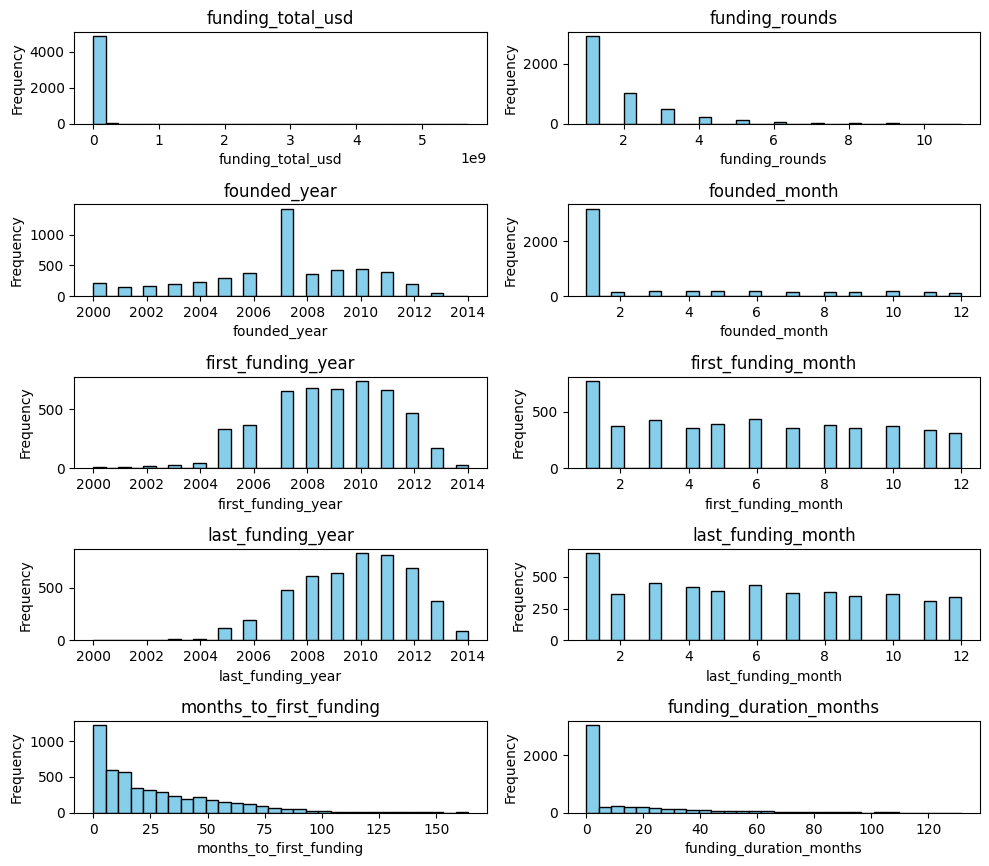

In [70]:
plt.figure(figsize=(10, 60))

for i, col in enumerate(numerical_att, 1):
    plt.subplot(35, 2, i)
    plt.hist(df_final[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

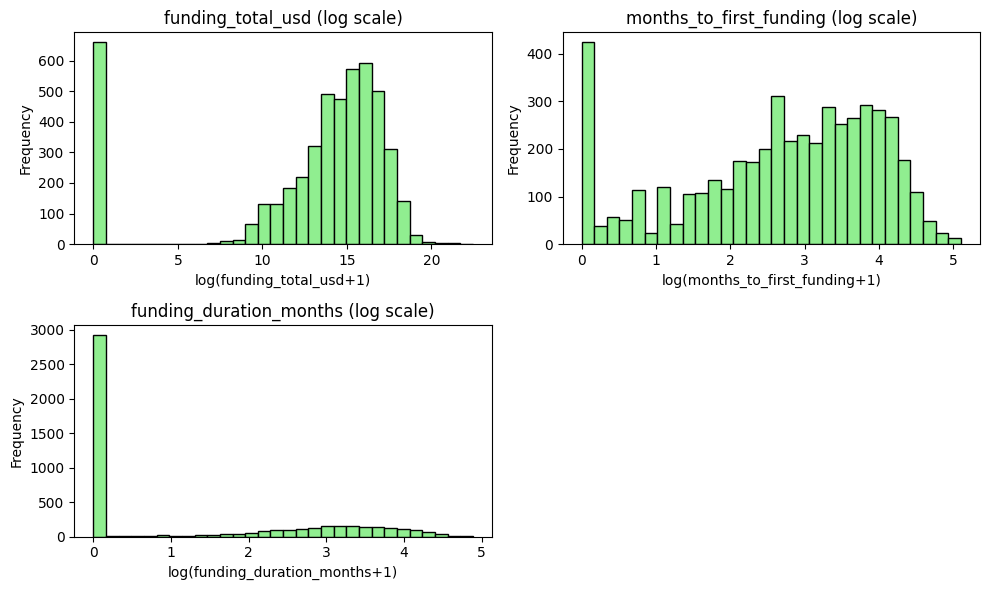

In [73]:
log_treatment = ['funding_total_usd', 'months_to_first_funding', 'funding_duration_months']

plt.figure(figsize=(10, 6))

for i, col in enumerate(log_treatment, 1):
    plt.subplot(2, 2, i)
    plt.hist(np.log1p(df_final[col]), bins=30, color='lightgreen', edgecolor='black')
    plt.title(f'{col} (log scale)')
    plt.xlabel(f'log({col}+1)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [22]:
# Apply log1p transformation to all numerical columns in df

for col in numerical:
    df[col] = np.log1p(df[col])

### **5. Exploratory Data Analysis (EDA)**
----

#### 5.1. Failure Distribution in Dataset

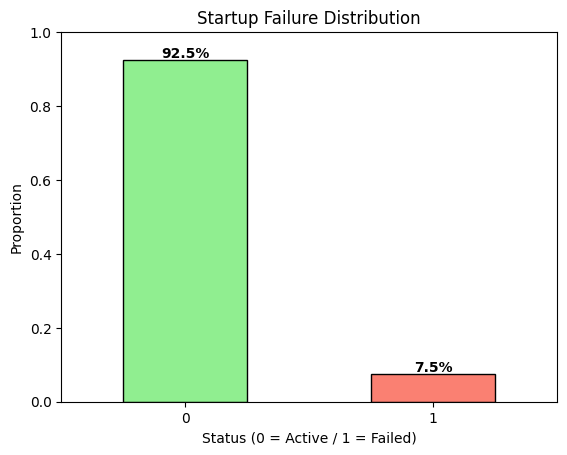

In [23]:
proportions = df['status_binary'].value_counts(normalize=True)

ax = proportions.plot(
    kind='bar',
    color=['lightgreen', 'salmon'],
    edgecolor='black'
)

plt.title('Startup Failure Distribution')
plt.xlabel('Status (0 = Active / 1 = Failed)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

for i, v in enumerate(proportions):
    plt.text(i, v + 0.005, f"{v*100:.1f}%", ha='center', fontweight='bold')

plt.ylim(0, 1)
plt.show()

# Only about 8% of startups are classified as failures, indicating a clear class imbalance that will be addressed during modeling.

#### 5.2. Failure Distribution by Categories

In [24]:
# To start the EDA, we define a minimum sample size to ensure the failure rate can be analyzed meaningfully.
# In statistics, the minimum sample size to estimate a proportion p with confidence level Z and margin of error E is:

# n = (Z^2 * p * (1 - p)) / E^2

Z = 1.96   # 95% confidence
p = 0.08   # expected failure rate (~8%)
E = 0.1    # margin of error 10%

n_min = (Z**2 * p * (1 - p)) / E**2
n_min = math.ceil(n_min)
print(f"Minimum sample size for estimating failure rate with 95% confidence and 10% error: {n_min}")


Minimum sample size for estimating failure rate with 95% confidence and 10% error: 29


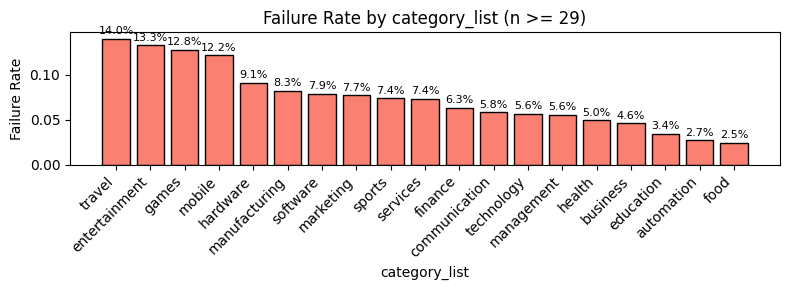

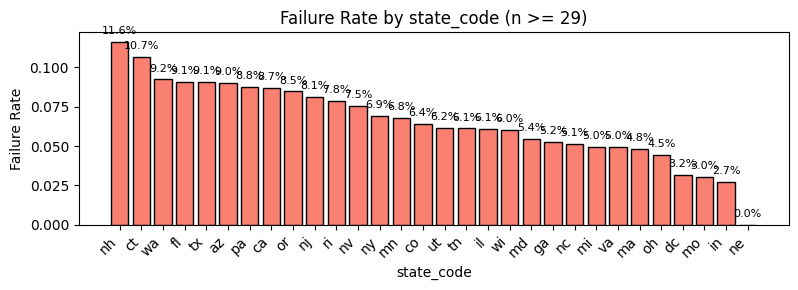

In [25]:
cat_valid = df['category_list'].value_counts()[df['category_list'].value_counts() >= n_min].index
state_valid = df['state_code'].value_counts()[df['state_code'].value_counts() >= n_min].index


for col in categorical:
    df_filtered = df[df[col].isin(cat_valid if col == 'category_list' else state_valid)]
    
    failure_rate = (
        df_filtered.groupby(col)['status_binary']
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    plt.figure(figsize=(8, 3))
    plt.bar(failure_rate[col], failure_rate['status_binary'], color='salmon', edgecolor='black')
    plt.title(f'Failure Rate by {col} (n >= {n_min})')
    plt.xlabel(col)
    plt.ylabel('Failure Rate')
    plt.xticks(rotation=45, ha='right')
    
    for i, v in enumerate(failure_rate['status_binary']):
        plt.text(i, v + 0.005, f"{v*100:.1f}%", ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Here we can highlight the riskiest groups in these two categories:
# Category_list: travel, entertainment, games, and mobile all have failure rates above 10%, indicating more challenging sectors.
# States: There are no extreme outliers, but NH and CT are slightly above the others in failure rate.

#### 5.3. Failure Distribution in Numerical Features

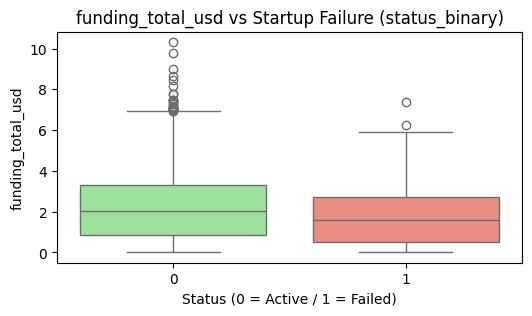

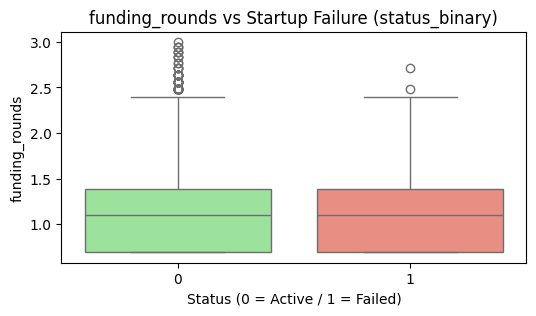

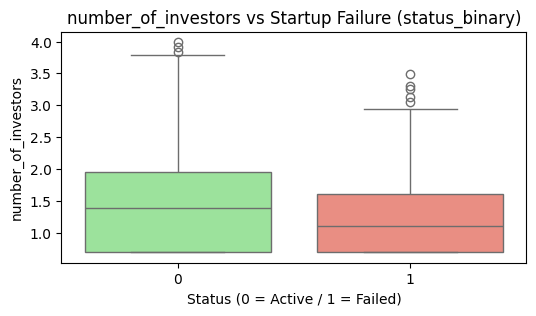

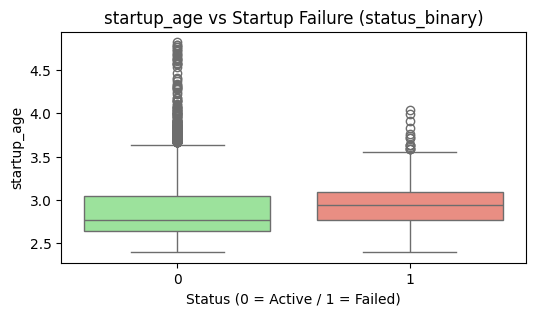

In [26]:
for col in numerical:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='status_binary', y=col, data=df, hue='status_binary', palette=['lightgreen', 'salmon'], dodge=False, legend=False)
    plt.title(f'{col} vs Startup Failure (status_binary)')
    plt.xlabel('Status (0 = Active / 1 = Failed)')
    plt.ylabel(f'{col}')
    plt.show()

# Insights from numerical features:
# - Funding_total_usd: Failed startups tend to have lower funding overall.
# - Funding_rounds: Very similar distribution between failed and active startups, not a strong indicator alone.
# - Number_of_investors: Failed startups generally have fewer investors.
# - Startup_age: Active startups are concentrated among younger ages but have more outliers; 
#                failed startups are slightly older on average but with a more stable distribution.

### **7. Preparing the Dataset**
----

In [34]:
from sklearn.metrics import mutual_info_score

mutual = {}
for i in categorical:
    a = round(mutual_info_score(df['status_binary'],df[i])*100,2)
    mutual[i] = a
df_mutual = pd.DataFrame(list(mutual.items()), columns=['feature', 'mutual_info (%)'])
df_mutual = df_mutual.sort_values(by="mutual_info (%)", ascending=False).reset_index(drop=True)
df_mutual


,feature,mutual_info (%)
0,category_list,0.35
1,state_code,0.30


In [35]:
df[numerical].corrwith(df['status_binary'])

funding_total_usd     -0.072375
funding_rounds        -0.090724
number_of_investors   -0.064769
startup_age            0.076935
dtype: float64

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# Here we need to use the stratify parameter because our dataset is very unbalanced.
# This ensures that the failure ratio (~8%) is preserved in train, validation, and test sets.

df_full_train, df_test = train_test_split(
    df, test_size=0.2, random_state=1, stratify=df['status_binary']
)

df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1, stratify=df_full_train['status_binary']
)

In [29]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_full_train = df_full_train['status_binary'].values
y_train = df_train['status_binary'].values
y_val = df_val['status_binary'].values
y_test = df_test['status_binary'].values

In [31]:
del df_full_train['status_binary']
del df_train['status_binary']
del df_val['status_binary']
del df_test['status_binary']

In [32]:
len(df_full_train), len(df_train), len(df_val), len(df_test)

(10970, 8227, 2743, 2743)